<a href="https://colab.research.google.com/github/MHRDYN7/Tensorflow-Keras/blob/main/Subclassing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [9]:
x_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [3]:
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

In [ ]:
#hints
"""
layers.Layer
layers.Conv2D(out_channels, kernel_size, padding="same")
layers.BatchNormalization()
"""

In [4]:

class ConvBlock(layers.Layer):
  def __init__(self, out_channels, kernal_size=3):
    super(ConvBlock,self).__init__()
    self.conv = layers.Conv2D(out_channels, kernal_size, padding="same")
    self.bn = layers.BatchNormalization()

  def call(self, input, training=False):
    x = self.conv(input)
    x = self.bn(x, training=training)
    return tf.nn.relu(x)


In [21]:
CB1 = ConvBlock(out_channels=3)

In [23]:
op = CB1(tf.expand_dims(x_train[0],0))

In [24]:
CB1(tf.expand_dims(x_train[0],0)).shape

TensorShape([1, 28, 28, 3])

In [11]:
from matplotlib import pyplot as plt

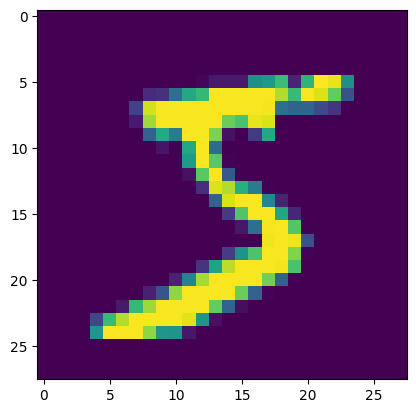

In [12]:
plt.imshow(x_train[0])

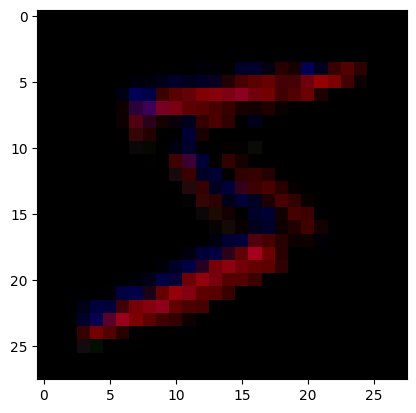

In [25]:
plt.imshow(tf.squeeze(op,0))

In [26]:
def IMEXP(img, epoch):
  image = img
  plt.imshow(image)
  for i in range(epoch):
    image = tf.squeeze(ConvBlock(out_channels=3)(tf.expand_dims(img,0)),0)
    print(f"epoch: {i}")
    plt.imshow(image)
    plt.show()

epoch: 0


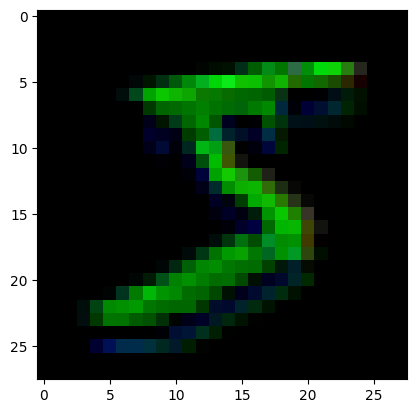

epoch: 1


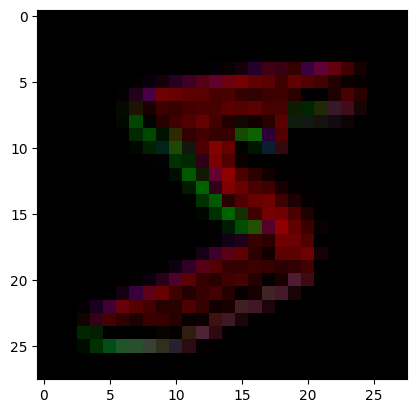

epoch: 2


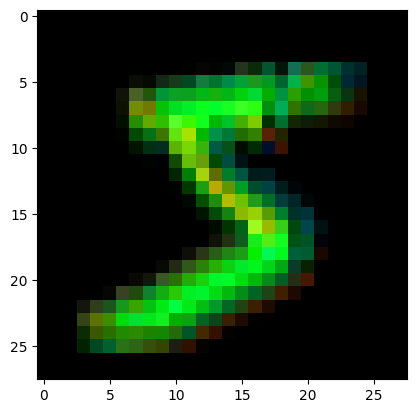

epoch: 3


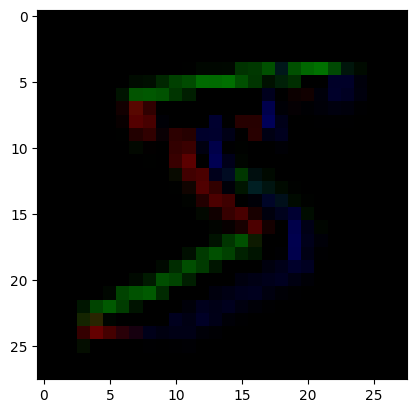

epoch: 4


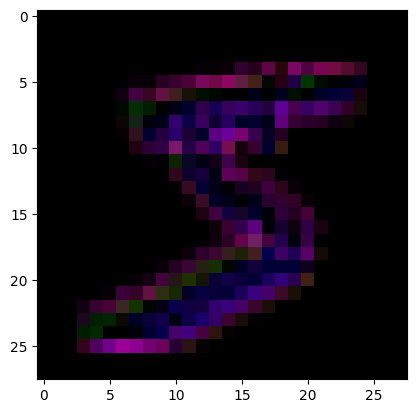

In [27]:
IMEXP(x_train[0], epoch=5)

In [5]:
class ResBlock(layers.Layer):
  def __init__(self, channels):
    super(ResBlock,self).__init__()
    self.channels = channels
    self.cnn1 = ConvBlock(channels[0], 3)
    self.cnn2 = ConvBlock(channels[1], 3)
    self.cnn3 = ConvBlock(channels[2], 3)
    self.pooling = layers.MaxPooling2D()
    self.identity_mapping = layers.Conv2D(channels[1], 1, padding="same")

  def call(self, input, training=False):
    x = self.cnn1(input, training=training)
    x = self.cnn2(x, training=training)
    x = self.cnn3(x+self.identity_mapping(input), training=training)
    x = self.pooling(x)
    return x

In [6]:
class ResModel(keras.Model):
  def __init__(self,num_classes=10):
    super(ResModel, self).__init__()
    self.block1 = ResBlock([32, 32, 64])
    self.block2 = ResBlock([128, 128, 256])
    self.block3 = ResBlock([128, 256, 512])
    self.pool = layers.GlobalAveragePooling2D()
    self.classifier = layers.Dense(num_classes)

  def call(self, input, training=False):
    x = self.block1(input, training=training)
    x = self.block2(x, training=training)
    x = self.block3(x, training=training)
    x = self.pool(x)
    x = self.classifier(x)
    return x

  def model(self):
    inputs = keras.Input(shape=(28, 28, 1))
    outputs = self.call(inputs)
    return keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model = ResModel().model()

In [43]:
model.layers

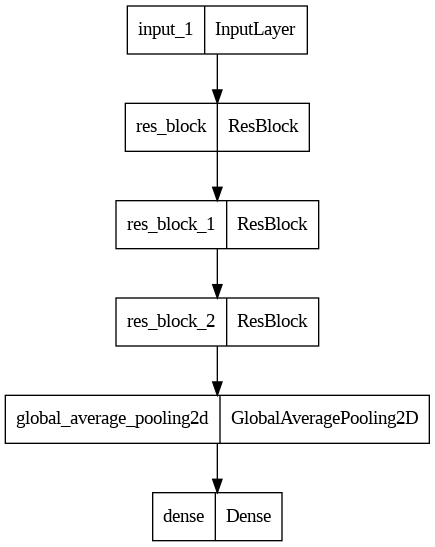

In [8]:
keras.utils.plot_model(model)

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],)


In [10]:
model.fit(x_train, y_train, batch_size=64, epochs=1, verbose=2)

938/938 - 38s - loss: 0.1659 - accuracy: 0.9471 - 38s/epoch - 40ms/step


In [13]:
model.evaluate(x_test, y_test, batch_size=64, verbose=2)

157/157 - 1s - loss: 0.0355 - accuracy: 0.9882 - 1s/epoch - 9ms/step


[0.035547561943531036, 0.9882000088691711]

In [15]:
model.predict(tf.expand_dims(x_test[5],0))

1/1 [==============================] - 1s 942ms/step


array([[ -2.7148793 ,  14.865531  ,  -6.6041765 , -11.012579  ,
         -2.0694096 ,  -4.7125535 ,   1.9485322 ,   1.4326991 ,
         -0.94430614,  -1.3660767 ]], dtype=float32)

In [16]:
from matplotlib import pyplot as plt

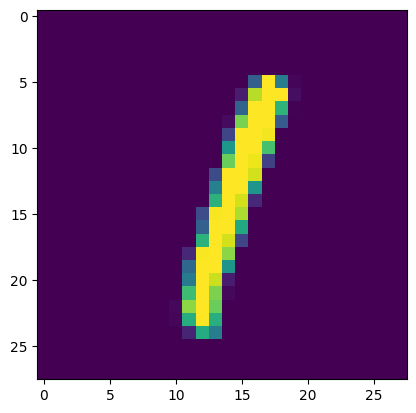

In [17]:
plt.imshow(x_test[5])

In [26]:
def sample_tests(num):
    sample = x_test[num]
    plt.imshow(sample)
    return tf.math.argmax(model.predict(tf.expand_dims(sample,0)), axis=1)

1/1 [==============================] - 0s 29ms/step


<tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>

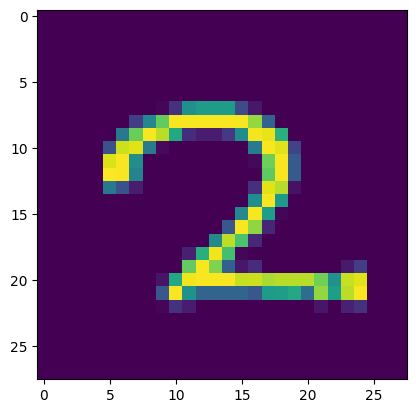

In [30]:
sample_tests(77)